# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [2232]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2233]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2234]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [2235]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [2236]:
# define a function to load json file to a dataframe

def load_json(path):
  with open(path,'r') as f:   # Open the json file in read mode
    data = json.load(f)       # load the json file
  df = pd.DataFrame(data)     # convert to pandas dataframe
  return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [2237]:
# read the json file by giving the file path and create a dataframe

df = load_json('/content/ingredient_and_quantity.json')   # provide the json file path while calling the load_json() function
df                                                        # created dataframe df

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                   6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                      2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                    1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3    500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                             1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                          

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [2238]:
# display first five rows of the dataframe - df

df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [2239]:
# print the dimensions of dataframe - df

print(f"Dimensions of the dataframe: {df.shape}")

Dimensions of the dataframe: (285, 2)


In [2240]:
# print the information of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [2241]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [2242]:
# display first five rows of the dataframe - df

df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [2243]:
# create input_length and pos_length columns for the input_tokens and pos-tokens

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)


In [2244]:
# check for the equality of input_length and pos_length in the dataframe

print((df['input_length'] == df['pos_length']).all())  # return false if the lengths for input and pos don't match for atleast one row


# check the mismatched rows

mismatched_rows = df[df['input_length'] != df['pos_length']]    # checking inequality between the lengths of input and pos tokens

print(len(mismatched_rows))

# There are 5 rows having unequal lengths

False
5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [2245]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(label_list):
  """
  Returns a set of all unique labels from a list of label sequences.
  Each item in label_list should be a list of labels.
  """
  uniq_lbls = set()
  for labels in label_list:
    uniq_lbls.update(labels)
  return uniq_lbls

unique_labels(df['pos_tokens'])

{'ingredient', 'quantity', 'unit'}

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [2246]:

mismatched_indexes = mismatched_rows.index.tolist()  # this will store the index of those rows where the input and pos length is not equal
print(f"Mismatched Indexes: {mismatched_indexes}")
print()


# Creating df to check misalignment between input_length and pos_length for better visualisation
mismatched_df = pd.DataFrame(mismatched_rows,columns=['input_length','pos_length'])
mismatched_df.head()


Mismatched Indexes: [17, 27, 79, 164, 207]



input_length  pos_length
17             15          14
27             37          36
79             38          37
164            54          53
207            18          17

<font color = red>[write your answer]</font> <br>

The indexes that require cleaning and formatting in the dataframe are as follows:

[17, 27, 79, 164, 207]

The above indexes must be dropped because there is a misalignment between input_length and pos_length. Since this is a Named Entity Recognition (NER) task, each token (input word) must correspond to exactly one label. Keeping these inconsistent rows would result in training errors, as the model expects a 1-to-1 mapping between inputs and labels.

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [2247]:
# drop the irrelevant recipe data

# Since we're preparing data for an NER model,
# each input token must have exactly one corresponding POS/NER label.
# Misaligned sequences can cause issues during training, so we drop such rows.

df.drop(mismatched_indexes,inplace=True)

print("Dropped Mismatched Rows: ")
print(mismatched_rows[['input_length','pos_length']])

Dropped Mismatched Rows: 
     input_length  pos_length
17             15          14
27             37          36
79             38          37
164            54          53
207            18          17


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [2248]:
# update the input and pos length in input_length and pos_length

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [2249]:
# validate the input length and pos length as input_length and pos_length

(df['input_length'] == df['pos_length']).all()


# Output is True that means the lengths match for input and pos tokens


np.True_

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [2250]:
# split the dataset into training and validation sets

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [2251]:
# print the first five rows of train_df

train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
179                                                        250 grams Okra Oil 1 Onion finely chopped Tomato Grated teaspoon Ginger 2 Garlic Finely 1/2 Cumin seeds 1/4 Teaspoon asafoetida cup cottage cheese pinched coriander powder mango red chilli turmeric                                                                                                                        quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient unit ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                  [250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]                                                                                                                                  [quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
57   200 grams Paneer Homemade Cottage Cheese 2 Potato Aloo Bay leaf tej patta Dry Red Chilli 1 tablespoon Panch Phoran Masala roasted and powdered Tomato big sized teaspoon Turmeric powder Haldi Cumin seeds Jeera Ginger grated Salt 1/2 Sugar Sunflower Oil  quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient  [200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ing

In [2252]:
# print the first five rows of the val_df

val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                                                                                                        input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos_tokens  input_length  pos_length
35                                                                                                                                                                                                                                                                                       1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi                                                                                                                                                                                                                                                                                                                                                                                                                                                     quantity unit ingredient quantity unit ingredient quantity ingredient unit ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                               [1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          15
111  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to small florets Onion tablespoon Ginger Garlic Paste Salt teaspoons Sunflower Oil 1/2 cup Fresh coconut grated teaspoon Whole Black Peppercorns Green Chillies Fennel seeds Saunf Poppy 6 Cashew nuts inch Cinnamon Stick Dalchini Star anise 3 Cloves Laung Cardamom Elaichi P

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [2253]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()


In [2254]:
# validate the shape of training and validation samples

# print lengths

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")

print(f"Length of X_val: {len(X_val)}")
print(f"Length of y_val: {len(y_val)}")


Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [2255]:
# Display the number of unique labels present in y_train

unique_labels_ytrain = unique_labels(y_train)
print(f"Number of unique labels in y_train: {len(unique_labels_ytrain)}")
print(unique_labels_ytrain)


Number of unique labels in y_train: 3
{'ingredient', 'unit', 'quantity'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [2256]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
  """
  Return flattened list from nested list
  """
  flattened_lst = []
  for lst in nested_list:
    flattened_lst.extend(lst)
  return flattened_lst


In [2257]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [2258]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens


def extract_and_validate_tokens(df, dataset_name):

  """
  Flattens 'input_tokens' and 'pos_tokens' from the DataFrame.
  Validates that the lengths of the flattened lists are equal.
  Prints first 10 records of input_tokens and pos_tokens
  Returns flattened input_tokens and pos_tokens

  """
  input_tokens = flatten_list(df['input_tokens'].tolist())
  pos_tokens = flatten_list(df['pos_tokens'].tolist())

  print(f"Length of {dataset_name} input_tokens: {len(input_tokens)}")
  print(f"Length of {dataset_name} pos_tokens: {len(pos_tokens)}")

  print(f"First 10 records of {dataset_name} input_tokens: {input_tokens[:10]}")
  print(f"First 10 records of {dataset_name} pos_tokens: {pos_tokens[:10]}")

  return input_tokens,pos_tokens


In [2259]:
# extract the tokens and its pos tags

input_tokens, pos_tokens = extract_and_validate_tokens(train_df, dataset_name)


Length of Training input_tokens: 7114
Length of Training pos_tokens: 7114
First 10 records of Training input_tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 records of Training pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [2260]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays


def categorize_tokens(tokens, pos_tags):

  """
  Initializes three lists for ingredients, units, and quantities.
  Validates that all POS tags are in the allowed list; otherwise, returns empty arrays.
  Returns categorized ingredients, units, and quantities based on the POS tags.

  """
  ingredients = []
  units = []
  quantities = []

  # Returns empty array if below labels is not in pos_tags
  pos_labels_allowed_ = {'ingredient','unit','quantity'}

  for pos_tag in pos_tags:
    if pos_tag not in pos_labels_allowed_:
      return [],[],[]


  # Based on the pos_tags it appends token in the respective list
  for token, pos_tag in zip(tokens, pos_tags):
    if pos_tag == 'ingredient':
      ingredients.append(token)
    elif pos_tag == 'unit':
      units.append(token)
    elif pos_tag == 'quantity':
      quantities.append(token)


  return ingredients, units, quantities


In [2261]:
#  call the function to categorise the labels into respective list

ingredients, units, quantities = categorize_tokens(input_tokens, pos_tokens)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [2262]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items


def get_top_frequent_items(item_list, pos_label, dataset_name):

  """
  Uses Counter to count items in item_list.
  Finds and prints the top 10 most frequent items.
  Returns the top items as a list of (item, count) tuples.

  """
  item_counts = Counter(item_list)
  top_items = item_counts.most_common(10)

  print(f"Top 10 most frequent {pos_label} in {dataset_name}:")

  for item, count in top_items:
    print(f"{item}: {count}")

  print()
  return top_items


In [2263]:
# get the top ingredients which are frequently seen in the recipe

ingredients_top_items = get_top_frequent_items(ingredients,'ingredient',dataset_name)


Top 10 most frequent ingredient in Training:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65



In [2264]:
# get the top units which are frequently seen in the recipe

units_top_items = get_top_frequent_items(units,'unit',dataset_name)

Top 10 most frequent unit in Training:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39



#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [2265]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items, label, dataset_name):

  """
  Plots a bar graph for the top items.

  """
  plt.figure(figsize=(10, 6))
  items, counts = zip(*top_items)
  ax = sns.barplot(x = items, y = counts)

  # Add annotations for bars
  for i, count in enumerate(counts):
        ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

  plt.xlabel(label)
  plt.ylabel('Frequency')
  plt.title(f'Top 10 Most Frequent {label} in {dataset_name} Dataset')
  plt.xticks(rotation=45, ha='right')
  plt.show()


#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



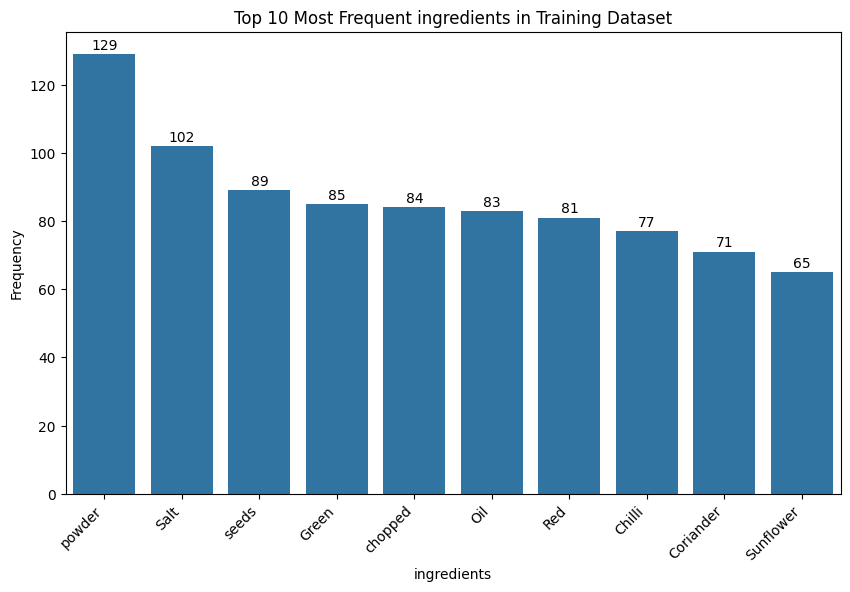

In [2266]:
# plot the top frequent ingredients in training data

plot_top_items(ingredients_top_items, 'ingredients', dataset_name)

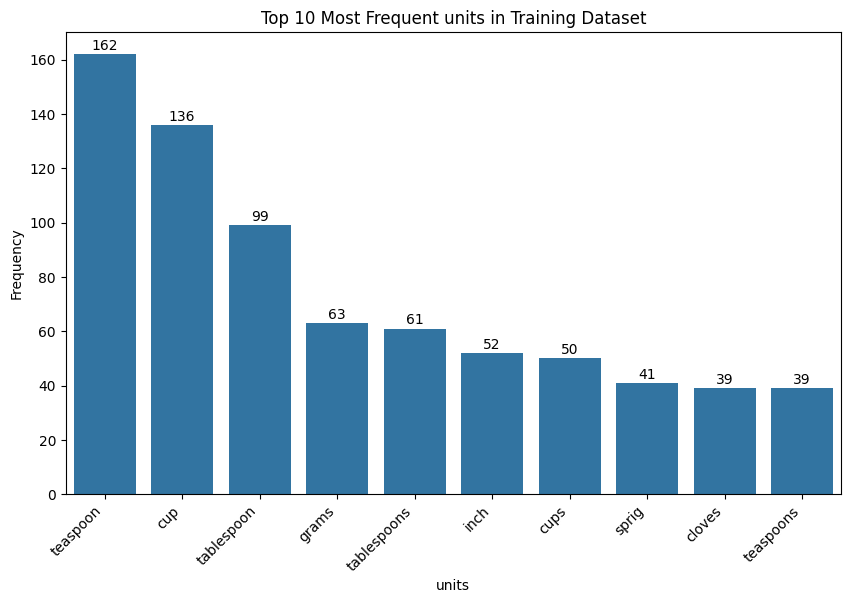

In [2267]:
# plot the top frequent units in training data

plot_top_items(units_top_items, 'units', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [2268]:
# initialise the dataset_name

dataset_name = 'Validation'


In [2269]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe

input_tokens, pos_tokens = extract_and_validate_tokens(val_df, dataset_name)

val_ingredients, val_units, val_quantities = categorize_tokens(input_tokens, pos_tokens)

Length of Validation input_tokens: 2876
Length of Validation pos_tokens: 2876
First 10 records of Validation input_tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 records of Validation pos_tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']


In [2270]:
val_ingredients_top_items = get_top_frequent_items(val_ingredients,'ingredient',dataset_name)

val_units_top_items = get_top_frequent_items(val_units,'unit',dataset_name)

Top 10 most frequent ingredient in Validation:
powder: 54
Salt: 47
Oil: 39
Red: 39
seeds: 36
Chilli: 36
chopped: 31
Green: 30
Leaves: 29
Coriander: 27

Top 10 most frequent unit in Validation:
teaspoon: 59
cup: 57
tablespoon: 32
tablespoons: 32
cups: 24
sprig: 21
inch: 20
grams: 19
teaspoons: 18
cloves: 16



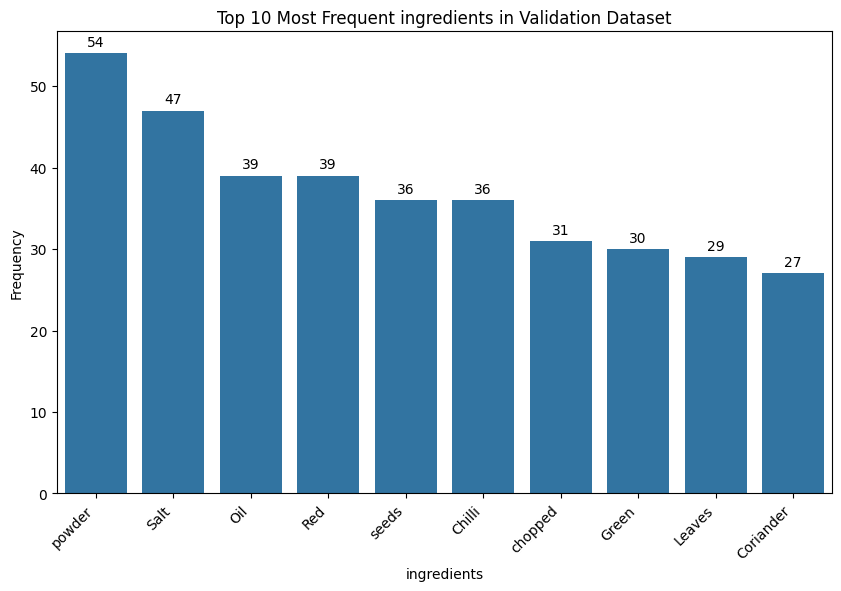

In [2271]:
# plot the top frequent ingredients in validation data

plot_top_items(val_ingredients_top_items, 'ingredients', dataset_name)

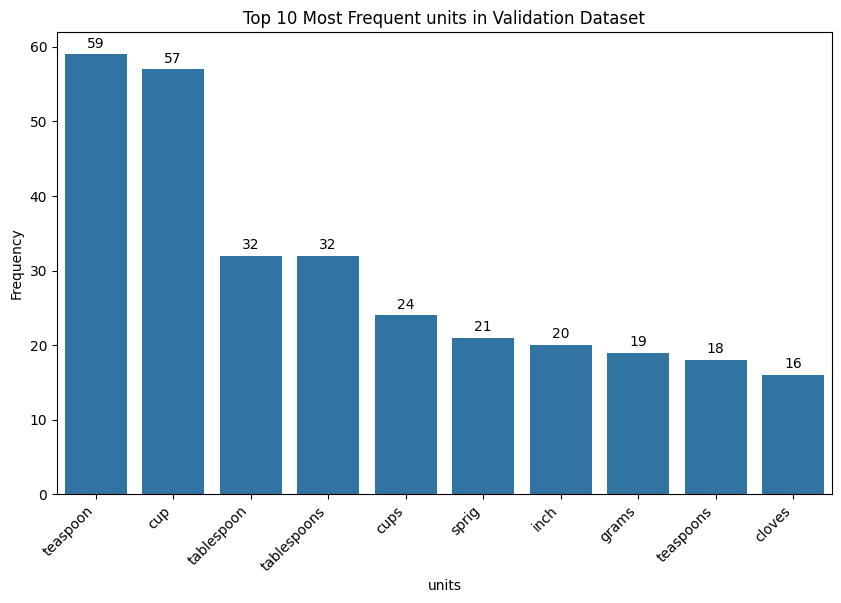

In [2272]:
# plot the top frequent units in training data

plot_top_items(val_units_top_items, 'units', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [2273]:
# define unit and quantity keywords along with quantity pattern

unit_keywords = {
    # Volume
    "teaspoon", "teaspoons", "tsp", "tspn",
    "tablespoon", "tablespoons", "tbsp", "tbl", "tbs",
    "cup", "cups", "c",
    "fluid ounce", "fluid ounces", "fl oz", "fl. oz.",
    "pint", "pints", "pt",
    "quart", "quarts", "qt",
    "gallon", "gallons", "gal",
    "ml", "milliliter", "milliliters", "millilitre", "millilitres",
    "l", "liter", "liters", "litre", "litres",
    "dash", "dashes",
    "gill", "gills",
    "bushel", "bushels",

    # Weight
    "mg", "milligram", "milligrams", "milligramme", "milligrammes",
    "g", "gram", "grams", "gramme", "grammes",
    "kg", "kilogram", "kilograms", "kilogramme", "kilogrammes",
    "oz", "ounce", "ounces",
    "lb", "lbs", "pound", "pounds",
    "stone", "stones",

    # Count/Container
    "clove", "cloves",
    "slice", "slices",
    "piece", "pieces", "pc", "pcs",
    "stick", "sticks",
    "bunch", "bunches",
    "head", "heads",
    "can", "cans",
    "packet", "packets", "pkg", "pkgs",
    "box", "boxes",
    "jar", "jars",
    "bottle", "bottles",
    "bag", "bags",
    "drop", "drops",
    "sprig", "sprigs",
    "sheet", "sheets",
    "package", "packages",
    "container", "containers",
    "carton", "cartons",
    "tin", "tins",

    # Informal
    "pinch", "dash", "splash", "handful", "touch",
    "glug", "knob", "nub", "smidgen", "dollop"
}

quantity_keywords = {
    "half", "quarter", "third", "one-third", "two-thirds", "three-quarters",
    "few", "some", "several", "couple", "whole", "full",
    "heaping", "heaped", "level", "scant"
}

quantity_pattern = r"""
    \b
    (
        \d+([.,]\d+)?                # Decimals (1.5 or 1,5)
        |\d+\s*/\s*\d+                # Simple fractions (1/2 or 11/12)
        |\d+\s+\d+/\d+                # Mixed numbers with spaces (1 1/2)
        |\d+-\d+/\d+                  # Hyphenated mixed numbers (1-1/12)
        |[½⅓⅔¼¾⅕⅖⅗⅘⅙⅚⅐⅛⅜⅝⅞⅑⅒]        # Unicode fractions
        |\d+-\d+                      # Ranges (1-2)
        |a\s+(dozen|pinch)            # "a dozen", "a pinch"
        |\d+x                         # "2x"
    )
    \b
"""

In [2274]:
# load spaCy model

nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [ ]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):

    # Process the entire sentence with spaCy

    token = sent[i]

    # Skip space tokens entirely
    if token.is_space:
        return None  

    word = token.text.lower()

    # --- Core Features ---
    core_features = {
        'bias': 1.0,
        'token': word,
        'lemma': token.lemma_,
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.like_num,
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': token.is_punct,

    }

    # --- Improved Quantity & Unit Detection ---

    quantity_unit_features = {
        'is_quantity': bool(re.match(quantity_pattern, word)) or word in quantity_keywords,
        'is_unit': word in unit_keywords,
        'is_numeric': word.replace('.', '', 1).isdigit(),
        'is_fraction': '/' in word,
        'is_decimal': '.' in word,
        'preceding_word': sent[i - 1].text.lower() if i > 0 else '__BOS__',
        'following_word': sent[i + 1].text.lower() if i < len(sent) - 1 else '__EOS__',
        'has_fraction': any(c in token.text for c in ['/', '.', '½']),
        'next_is_measurement': i < len(sent)-1 and sent[i+1].text.lower() in unit_keywords,
        'is_after_number': i > 0 and sent[i-1].like_num,
        'is_measurement_word': token.text.lower() in unit_keywords,
        'is_quantity_word': token.text.lower() in quantity_keywords,
        'is_measurement': bool(re.match(quantity_pattern, token.text)),
        'is_measurement_unit': token.text.lower() in unit_keywords,
        'is_measurement_quantity': token.text.lower() in quantity_keywords,
        'is_measurement_ingredient': not (token.text.lower() in unit_keywords or bool(re.match(quantity_pattern, token.text))),

        'is_quantity': (
        bool(re.match(quantity_pattern, word)) or
        word in quantity_keywords or
     
        bool(re.match(r'^\d+-\d+/\d+$', word)) or
        (i > 0 and sent[i-1].like_num and word.startswith('-') and
        bool(re.match(r'^\d+/\d+$', word[1:])))
        ),

        
        'is_hyphenated_quantity': bool(re.match(r'^\d+-\d+/\d+$', word)),
        'is_split_quantity': (
            i > 0 and
            sent[i-1].like_num and
            word.startswith('-') and
            bool(re.match(r'^\d+/\d+$', word[1:]))
        ),

      
        'is_quantity_sequence': (
            (i > 0 and sent[i-1].like_num and word == '/') or
            (i > 1 and sent[i-2].like_num and sent[i-1].text == '-' and word == '/')
        ),

     
        'is_unit': (
            word in unit_keywords and
            not bool(re.match(r'^\d+-\d+/\d+$', word))  
        ),

       
        'is_quantity_then_unit': (
            bool(re.match(quantity_pattern, word)) and
            i < len(sent)-1 and
            sent[i+1].text.lower() in unit_keywords
        ),
        'is_hyphenated_quantity_then_unit': (
            bool(re.match(r'^\d+-\d+/\d+$', word)) and
            i < len(sent)-1 and
            sent[i+1].text.lower() in unit_keywords
        ),

        # Numeric properties
        'is_numeric': word.replace('.', '', 1).isdigit(),
        'is_fraction': '/' in word and not word.startswith('/'),
        'is_decimal': '.' in word,
        'has_number_hyphen_fraction': (
            any(char.isdigit() for char in word) and
            '-' in word and
            any(c in word for c in ['/', '.', '½'])
        )

    }

    # --- Contextual Features ---

    context_features = {
        'prev_token': sent[i - 1].text.lower() if i > 0 else '__BOS__',
        'prev_is_quantity': bool(re.match(quantity_pattern, sent[i - 1].text)) if i > 0 else False,
        'prev_is_digit': sent[i - 1].like_num if i > 0 else False,
        'BOS': i == 0,
        'next_token': sent[i + 1].text.lower() if i < len(sent) - 1 else '__EOS__',
        'next_is_unit': sent[i + 1].text.lower() in unit_keywords if i < len(sent) - 1 else False,
        'next_is_ingredient': not (sent[i + 1].text.lower() in unit_keywords or
                                   bool(re.match(quantity_pattern, sent[i + 1].text))) if i < len(sent) - 1 else False,
        'EOS': i == len(sent) - 1,
        'prev_is_cooking_verb': i > 0 and sent[i-1].lemma_ in ['add', 'mix', 'stir']
    }


    return {**core_features, **quantity_unit_features, **context_features}

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [2276]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
  return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [2277]:
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex
import re

# using this for tokens like 1-1/12 since spacy seperates it as 1,-,1/2

infixes = list(nlp.Defaults.infixes)
infixes.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")  # remove splitting between numbers on `-`
infix_regex = compile_infix_regex(infixes)

# Apply custom tokenizer
nlp.tokenizer = Tokenizer(nlp.vocab,
                          rules=nlp.Defaults.tokenizer_exceptions,
                          prefix_search=nlp.tokenizer.prefix_search,
                          suffix_search=nlp.tokenizer.suffix_search,
                          infix_finditer=infix_regex.finditer,
                          token_match=nlp.tokenizer.token_match)


In [2278]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features


# Tokenize each sentence in X_train and X_val using spaCy
X_train = [nlp(sent if isinstance(sent, str) else " ".join(sent)) for sent in X_train]
X_val = [nlp(sent if isinstance(sent, str) else " ".join(sent)) for sent in X_val]

# Now generate features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [2279]:
# Convert labels into list as y_train_labels and y_val_labels

# y_train and y_val are lists

y_train_labels = y_train
y_val_labels = y_val

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [2280]:
# print the length of train features and labels

print(f"Length of X_train_features: {len(X_train_features)}")
print(f"Length of X_val_features: {len(X_val_features)}")


Length of X_train_features: 196
Length of X_val_features: 84


In [2281]:
# print the length of validation features and labels

print(f"Length of y_train_labels: {len(y_train_labels)}")
print(f"Length of y_val_labels: {len(y_val_labels)}")


Length of y_train_labels: 196
Length of y_val_labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [2282]:
# Flatten labels in y_train

y_train_flat = flatten_list(y_train)


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [2283]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())


In [2284]:
label_counts

# We can observe that there is a class imbalance between quantity, unit and ingredient

Counter({'quantity': 980, 'unit': 811, 'ingredient': 5323})

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [2285]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {label: total_samples / count for label, count in label_counts.items()}

weight_dict

{'quantity': 7.259183673469388,
 'unit': 8.771886559802713,
 'ingredient': 1.336464399774563}

In [2286]:
# penalise ingredient label

# Since ingredient is dominating, we will penalize it to get lower weight

weight_dict['ingredient'] = weight_dict['ingredient'] * 0.1
weight_dict

{'quantity': 7.259183673469388,
 'unit': 8.771886559802713,
 'ingredient': 0.13364643997745632}

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [2287]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)

def extract_features_with_class_weights(sentences, labels, class_weights):
    """
    Verifies misalignment between tokens and labels
    Adding class weights for labels unit, ingredient and quantity
    """
    X_features = []
    y_aligned = []
    sample_weights = []

    for sent, sent_labels in zip(sentences, labels):
        if isinstance(sent[0], str):
            sent = nlp(" ".join(sent))

        tokens = [t for t in sent if not t.is_space]

        if len(tokens) != len(sent_labels):
            min_len = min(len(tokens), len(sent_labels))
            tokens = tokens[:min_len]
            sent_labels = sent_labels[:min_len]

        sent_features = [word2features(sent, i) for i, t in enumerate(sent)
                        if not t.is_space][:len(sent_labels)]

        weights = [class_weights.get(label, 1.0)
                  for label in sent_labels
                  if label in {'quantity', 'unit', 'ingredient'}]

        X_features.append(sent_features)
        y_aligned.append(sent_labels)
        sample_weights.append(weights)

    return X_features, y_aligned, sample_weights


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [2288]:
# Apply manually computed class weights

X_train_weighted_features, y_train_weighted_labels, train_weights = extract_features_with_class_weights(X_train, y_train_labels, weight_dict)
X_val_weighted_features, y_val_weighted_labels, val_weights = extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

In [2289]:
print(len(X_train_weighted_features))
print(len(y_train_weighted_labels))

print(len(X_val_weighted_features))
print(len(y_val_weighted_labels))

196
196
84
84


In [2290]:
# Verify weighted features and labels are equal in length

print(len(X_train_weighted_features) == len(y_train_weighted_labels))
print(len(X_val_weighted_features) == len(y_val_weighted_labels))

True
True


In [2291]:
# check unique y train weighted labels

unique_labels = set(flatten_list(y_train_weighted_labels))
unique_labels

{'ingredient', 'quantity', 'unit'}

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [2292]:
# initialise CRF model with the specified hyperparameters and use weight_dict

from sklearn_crfsuite import CRF
crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True,
)

# train the CRF model with the weighted training data

crf_model.fit(X_train_weighted_features, y_train_weighted_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [2293]:
# evaluate on the training dataset

y_pred_train = crf_model.predict(X_train_weighted_features)


In [2294]:
# specify the flat classification report by using training data for evaluation

print(flat_classification_report(y_train_weighted_labels, y_pred_train))

              precision    recall  f1-score   support

  ingredient       0.98      0.99      0.98      5323
    quantity       0.96      0.95      0.96       980
        unit       0.94      0.92      0.93       811

    accuracy                           0.97      7114
   macro avg       0.96      0.95      0.96      7114
weighted avg       0.97      0.97      0.97      7114



In [2295]:
# create a confusion matrix on training datset

print(confusion_matrix(flatten_list(y_train_weighted_labels), flatten_list(y_pred_train)))

# plot confusion matrix

cm = confusion_matrix(flatten_list(y_train_weighted_labels), flatten_list(y_pred_train))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')


[[5248   33   42]
 [  49  928    3]
 [  63    1  747]]


Text(70.72222222222221, 0.5, 'True')

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [2296]:
# dump the model using joblib as crf_model.pkl

import joblib
joblib.dump(crf_model, 'crf_model.pkl')


['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [2297]:
# predict the crf model on validation dataset

y_pred_val = crf_model.predict(X_val_weighted_features)

In [2298]:
# specify flat classification report

print(flat_classification_report(y_val_weighted_labels, y_pred_val))

              precision    recall  f1-score   support

  ingredient       0.97      0.98      0.98      2107
    quantity       0.97      0.95      0.96       411
        unit       0.93      0.87      0.90       358

    accuracy                           0.96      2876
   macro avg       0.95      0.93      0.94      2876
weighted avg       0.96      0.96      0.96      2876



[[2072   13   22]
 [  18  390    3]
 [  46    1  311]]


Text(70.72222222222221, 0.5, 'True')

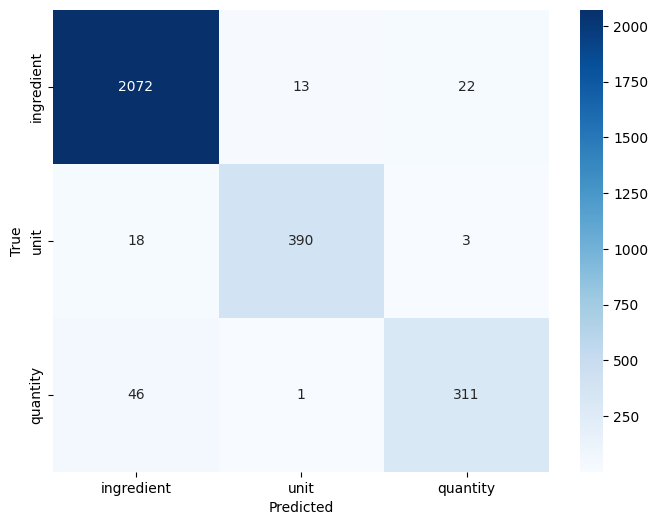

In [2299]:
# create a confusion matrix on validation dataset

print(confusion_matrix(flatten_list(y_val_weighted_labels), flatten_list(y_pred_val)))

# plot confusion matrix

cm = confusion_matrix(flatten_list(y_val_weighted_labels), flatten_list(y_pred_val))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [2300]:
# flatten Labels and Initialise Error Data

y_val_flat = flatten_list(y_val_weighted_labels)
y_pred_val_flat = flatten_list(y_pred_val)
error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [ ]:
# iterate and collect Error Information

from collections import defaultdict
def collect_error_analysis(X_val, y_val_labels, y_pred_val, weight_dict=None):
    """
    Collect detailed error analysis with context and token information

    Args:
        X_val: List of validation sentences (spaCy docs or token lists)
        y_val_labels: True labels (list of lists)
        y_pred_val: Predicted labels (list of lists)
        weight_dict: Dictionary of class weights for prioritization

    Returns:
        Tuple of (y_val_flat, y_pred_val_flat, error_data, error_counts)
    """
    y_val_flat = []
    y_pred_val_flat = []
    error_data = []
    error_counts = defaultdict(int)

    for sent_idx, (sent, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
        # Convert to spaCy Doc if needed
        if isinstance(sent[0], str):
            sent = nlp(" ".join(sent))

        tokens = [(i, t) for i, t in enumerate(sent) if not t.is_space]

        for (pos, token), true, pred in zip(tokens, true_labels, pred_labels):
            y_val_flat.append(true)
            y_pred_val_flat.append(pred)

            if true != pred:
                 # get previous and next tokens with handling for boundary cases
                prev_token = sent[pos-1].text if pos > 0 else '[START]'
                next_token = sent[pos+1].text if pos < len(sent)-1 else '[END]'

             
                ctx_start = max(0, pos-2)
                ctx_end = min(len(sent), pos+3)
                context = [t.text for t in sent[ctx_start:ctx_end]]
                context_pos = [t.pos_ for t in sent[ctx_start:ctx_end]]

                # Record error details
                error_entry = {
                    'sentence_id': sent_idx,
                    'token': token.text,
                    'token_pos': token.pos_,
                    'token_lemma': token.lemma_,
                    'true_label': true,
                    'pred_label': pred,
                    'prev_token': prev_token,
                    'prev_pos': sent[pos-1].pos_ if pos > 0 else None,
                    'next_token': next_token,
                    'next_pos': sent[pos+1].pos_ if pos < len(sent)-1 else None,
                    'context': context,
                    'context_pos': context_pos,
                    'class_weight': weight_dict.get(true, 1.0) if weight_dict else 1.0,
                    'is_major_error': (true in ['quantity', 'unit'] and pred == 'ingredient')
                }
                error_data.append(error_entry)
                error_counts[(true, pred)] += 1

    return y_val_flat, y_pred_val_flat, error_data, error_counts


# Call the function

y_val_flat, y_pred_val_flat, error_data, error_counts = collect_error_analysis(X_val, y_val_labels, y_pred_val, weight_dict)


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [2302]:
# Create DataFrame and Print Overall Accuracy
from sklearn.metrics import accuracy_score as sk_accuracy
error_df = pd.DataFrame(error_data)

error_df.head()

accuracy = sk_accuracy(y_val_flat, y_pred_val_flat)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 96.42%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [2303]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

label_total = defaultdict(int)
label_correct = defaultdict(int)

for y_true, y_pred in zip(y_val_flat, y_pred_val_flat):
    label_total[y_true] += 1
    if y_true == y_pred:
        label_correct[y_true] += 1

label_accuracy_data = []
for label in label_total:
    accuracy = round((label_correct[label] / label_total[label]) * 100, 2)
    class_weight = weight_dict.get(label, 1.0)
    error_count = label_total[label] - label_correct[label]

    label_accuracy_data.append({
        'Label': label,
        'Total Tokens': label_total[label],
        'Correct Predictions': label_correct[label],
        'Errors': error_count,
        'Per-Class Accuracy (%)': accuracy,
        'Class Weight': class_weight
    })

label_analysis_df = pd.DataFrame(label_accuracy_data)

if not error_df.empty:
    # Ensure columns exist before merging
    if 'Per-Class Accuracy (%)' not in label_analysis_df:
        label_analysis_df['Per-Class Accuracy (%)'] = 0.0
    if 'Class Weight' not in label_analysis_df:
        label_analysis_df['Class Weight'] = 1.0

    error_df = error_df.merge(
        label_analysis_df[['Label', 'Per-Class Accuracy (%)', 'Class Weight']],
        left_on='true_label',
        right_on='Label',
        how='left'
    )
    error_df.drop(columns=['Label'], inplace=True)

display_columns = [
    'sentence_id', 'token', 'prev_token', 'next_token',
    'true_label', 'pred_label'
]

for col in ['Per-Class Accuracy (%)', 'Class Weight', 'context']:
    if col in error_df.columns:
        display_columns.append(col)

error_df_display = error_df[display_columns].head(10)

print("Label Analysis Summary:")
print(label_analysis_df.to_markdown(index=False))

print("\nSample Errors:")
print(error_df_display.to_markdown(index=False))

Label Analysis Summary:
| Label      |   Total Tokens |   Correct Predictions |   Errors |   Per-Class Accuracy (%) |   Class Weight |
|:-----------|---------------:|----------------------:|---------:|-------------------------:|---------------:|
| quantity   |            411 |                   390 |       21 |                    94.89 |       7.25918  |
| unit       |            358 |                   311 |       47 |                    86.87 |       8.77189  |
| ingredient |           2107 |                  2072 |       35 |                    98.34 |       0.133646 |

Sample Errors:
|   sentence_id | token      | prev_token   | next_token   | true_label   | pred_label   |   Per-Class Accuracy (%) |   Class Weight | context                                                |
|--------------:|:-----------|:-------------|:-------------|:-------------|:-------------|-------------------------:|---------------:|:-------------------------------------------------------|
|             4 | )  

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




Validation Dataset Insights:

1. High Overall Accuracy:
The model achieved a strong accuracy of 96.42%, indicating reliable predictions across the dataset.

2. Best Performing Class – Ingredient:
The ingredient class showed the best performance with 98.34% accuracy, benefiting from clear contextual cues and frequent occurrence in data.

3. Most Misclassified Class – Unit:
The unit class had the lowest accuracy (86.87%), with errors often caused by confusion with ingredients and quantities due to overlapping usage (e.g., “cloves”, “teaspoon”).

4. Frequent Confusions:
   Misclassifications like:

    - 1/2 (ingredient → quantity)

    - tablespoon (ingredient ↔ unit)

    - cloves (ingredient ↔ unit)
reflect semantic ambiguity and lack of phrase-level understanding.

5. Contextual Challenges:
Tokens surrounded by symbols or mixed numeric values (e.g., /, ), numbers) posed difficulties due to weak contextual signals at the token level.

6. Class Imbalance & Weight:
Classes like unit and quantity are underrepresented compared to ingredient, making them harder for the model to learn robustly.

7. Improvement Opportunities:

   - Incorporate rule-based post-processing for number-unit patterns (e.g., 3 tablespoons → quantity + unit).

   - Enrich training data with ambiguous or edge-case examples.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

# CRF Model Conclusion: Recipe Entity Recognition

---

## 1. Objective

To build a **Conditional Random Field (CRF)** model for extracting structured entities — **quantity**, **unit**, and **ingredient** — from unstructured recipe ingredient data.

---

## 2. Summary of Process and Findings

### a. Data Loading and Preparation
- JSON data was loaded into a Pandas DataFrame.
- Rows with mismatched token-label lengths were identified and removed.
- Data was split into:
  - **Training set**: 70%  
  - **Validation set**: 30%

---

### b. Exploratory Data Analysis (EDA)
- Most frequent entities observed:
  - **Ingredients**: `"powder"`, `"Salt"`, `"seeds"`
  - **Units**: `"teaspoon"`, `"cup"`, `"tablespoon"`
- Label distribution showed **class imbalance**:
  - `ingredient` → most frequent  
  - `quantity` and `unit` → less frequent
- Visualizations supported these patterns in both training and validation sets.

---

### c. Feature Extraction
- Custom `word2features` function created using **spaCy**.
- Included:
  - Token-level features  
  - Contextual features  
  - Pattern-based indicators (for numbers, units, etc.)

---

### d. Class Weighting
- **Inverse frequency** method used for class weighting.
- Additional weight applied to underrepresented classes (`unit`, `quantity`) to reduce model bias.

---

### e. Model Building and Training
- CRF model configured with:
  - Algorithm: **L-BFGS**
  - Regularization: **L1 and L2**
  - Max iterations set
  - Enabled **all possible transitions**
- Model trained on **weighted training data**.

---

## Evaluation Results

### a. Training Set Performance
- **Accuracy**: 97%
- High **precision**, **recall**, and **f1-score** for all classes
- Indicates strong learning from the training data

---

### b. Validation Set Performance
- **Overall Accuracy**: 96.42%
- Per-class performance:
  - `ingredient`: **98.34%**
  - `quantity`: **94.89%**
  - `unit`: **86.87%** (lowest)

---

### c. Confusion Matrix Observations
- Minimal errors for `ingredient`
- Common misclassifications:
  - `unit` vs `ingredient`
  - `quantity` vs `ingredient`

---

### d. Error Analysis
- Frequent issues:
  - **Ambiguous tokens** like `"cloves"`, `"teaspoon"`
  - **Punctuation** symbols (e.g., `")"`) within ingredient phrases
  - **Numeric tokens** like `"1/2"` misclassified due to weak context
- Indicates that local context alone may be insufficient for perfect classification

---

## 4. Conclusion

- CRF model is effective for recipe entity recognition
- **Performs well** on `ingredient` and `quantity` classes
- **Struggles more** with the `unit` class due to ambiguity and low frequency

---

## Final Verdict

The CRF pipeline — including data cleaning, feature engineering, and class weighting — builds a **strong foundation** for structured recipe extraction. The model achieves **high accuracy** and can be further improved with deeper context modeling and additional data.

